In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as mplot
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.colors import ListedColormap
import os
import subprocess
import sklearn

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,  precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
 
from sklearn.tree import export_graphviz
import pydotplus
import seaborn as sns

import random
 


from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist 
 
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.metrics import AUC, Precision, Recall, F1Score
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import pickle 

import shap
import lime
from lime import lime_tabular
import random

import dalex as dx 

from tabulate import tabulate 

# Define custom metrics
recall = Recall()
precision = Precision()
f1_score = F1Score()
auc = AUC()



In [2]:
dataSetIndex = 4
needToMakePictureOfTrees = 0
''' ---------------------------------------------------------- '''
dataSetFilePath = ""
dataSetName = ""
dataSetResultDirectory = "./"

if(dataSetIndex == 0):
    dataSetFilePath = "./heartDisease/0_statLog_dataSet.csv"
    dataSetName = "SateLog_DataSet"
elif (dataSetIndex == 1):
    dataSetFilePath = "./heartDisease/1_heart_statlog_cleveland_hungary_final.csv"
    dataSetName = "ALL_StateLog_CleveLand_Hungary"
elif (dataSetIndex == 2):
    dataSetFilePath = "./heartDisease/2_cleveland.csv"
    dataSetName = "Cleveland"
elif (dataSetIndex == 3):
    dataSetFilePath = "./heartDisease/3_framingham.csv"
    dataSetName = "framingham"
elif (dataSetIndex == 4):
    dataSetFilePath = "./heartDisease/4_CardiacPrediction.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 5):
    dataSetFilePath = "./heartDisease/5_CardiacPredictionLessDimensions.xlsx"
    dataSetName = "CardiacPrediction"
elif (dataSetIndex == 6):
    dataSetFilePath = "./heartDisease/6_CardiacPredictionFewDimensions.xlsx"
    dataSetName = "CardiacPrediction"
else:
    dataSetFilePath = ""
    dataSetName = ""

if(dataSetIndex==4 or dataSetIndex==5 or dataSetIndex==6):
    #fileData = pd.read_excel(dataSetFilePath, sheet_name='CoroHeartDis')
    fileData = pd.read_excel(dataSetFilePath)
else:
    fileData = pd.read_csv(dataSetFilePath)

print("Shape of fileData: {}".format(fileData.shape))
print("Column Headings: {}".format(fileData.__dataframe__().column_names()))
print("Number of Records: {}".format(fileData.__dataframe__().num_rows()))


missingValues = fileData.isnull().any().sum()
print(f"\nNumber of Missing Values: {missingValues}")

num_rows_before = fileData.shape[0]
# Remove duplicate records based on all columns
fileData.drop_duplicates(inplace=True)
# Check the number of rows after removing duplicates
num_rows_after = fileData.shape[0]
# Print the number of duplicate records removed
num_duplicates_removed = num_rows_before - num_rows_after
print(f"Number of duplicate records removed: {num_duplicates_removed}")
 
 # Preprocess Steps from the ChatGPT
# 1. Handling Missing Values:
fileData = fileData.dropna()
print("Shape of fileData: {}".format(fileData.shape))              
#fileData.replace({'?': np.nan}).dropna().astype(float)
#fileData = fileData.fillna(0) 

fileData = fileData.fillna(0) 

print("Shape of fileData End: {}".format(fileData.shape))

finalResultTable = [ ['Index', 'Method', 'Accuracy %','Recall %','Precision %','F1 Score','AUC'], ]  


#X = fileData.drop(fileData.__dataframe__().column_names()[-1], axis=1)  # Features
#cols = ['Gender', 'Age','Annual-Family-Income', 'Cholesterol', 'Diabetes', 'Triglycerides', 'Red-Cell-Distribution-Width', 'X60-sec-pulse', 'Height', 'Albumin', 'Blood-Rel-Stroke', 'Blood-Rel-Diabetes', 'HDL', 'Moderate-work','Iron', 'Hemoglobin','Protein', 'SEQN'   ] 
#cols = ['Age','Gender','Blood-Rel-Stroke','Triglycerides','Blood-Rel-Diabetes','Cholesterol','Platelet-count','Diabetes','Albumin','Hemoglobin','Moderate-work','Diastolic','Protein','Height','X60-sec-pulse','White-Blood-Cells','Bilirubin','Hematocrit','HDL','Systolic' ] 

cols = ['Triglycerides','Blood-Rel-Diabetes','Gender','Blood-Rel-Stroke','Cholesterol','Body-Mass-Index','Diabetes','Diastolic','Basophils','Eosinophils','Height','Albumin','Phosphorus','Total-Cholesterol','LDH','Weight','Protein','White-Blood-Cells','AST','Uric.Acid']

X = fileData[cols]
Y = fileData[fileData.__dataframe__().column_names()[-1]]  # Labels

columns = fileData.__dataframe__().column_names() 
totalRecords = (fileData.__dataframe__().num_rows())

print("\n")
print("columns of x:: {} \n\n and features of X: {}".format(len(X.columns), X.columns))

dataSetResultDirectory = "./"
dataSetResultDirectory += ("DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_" + dataSetName)
dataSetResultDirectory += "/"
if not os.path.isdir(dataSetResultDirectory):
    os.makedirs(dataSetResultDirectory)

dataSetName += "_{}".format(fileData.shape)



print("Shape of fileData: {} , target Len:{}".format(fileData.shape, len(Y)))
print("X: {} , Y:{}".format(X.shape, Y.shape))
#print("\n\nX: head:: \n{}".format(X.head()))
#print("\n\nY: head::\n {}".format(Y.head()))

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
print("Target Column Name:: {} \n".format(fileData.__dataframe__().column_names()[-1]))
rus = RandomUnderSampler(random_state=42)
smote = SMOTE(random_state=42)
# Oversample the minority class using SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)
#X_test, y_test = rus.fit_resample(X_test, y_test)
X_test, y_test = smote.fit_resample(X_test, y_test) 

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\n X Train: Shape:: {}".format(X_train.shape))
print(" X Test: Shape:: {}".format(X_test.shape))   
positiveClass =  0
negativeClass = 0
for i in y_train:
    if(i == 0): negativeClass += 1
    if(i == 1): positiveClass += 1
print("Train DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Train DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Train DataSet Total Records:: {}".format(positiveClass + negativeClass)) 
print("\n\n") 
positiveClass =  0
negativeClass = 0
for i in y_test:
    if(i == 0): negativeClass += 1
    if(i == 1): positiveClass += 1
print("Test DataSet Positive Class Records:: {}".format(positiveClass)) 
print("Test DataSet Negative Class Records:: {}".format(negativeClass)) 
print("Test DataSet Total Records:: {}".format(positiveClass + negativeClass)) 

X_train_normalized = tf.keras.utils.normalize(X_train, axis=1)
X_test_normalized = tf.keras.utils.normalize(X_test, axis=1)

scaler = StandardScaler()
X_train_scaler = scaler.fit_transform(X_train)
X_test_scaler = scaler.fit_transform(X_test) 
# Our vectorized labels
X_train_f32 = np.asarray(X_train).astype(np.float32)  #.astype('float32').reshape((-1,1))
X_test_f32 = np.asarray(X_test).astype(np.float32)
#y_train_scaler = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test_scaler = np.asarray(y_test).astype('float32').reshape((-1,1))
# Separate features and target variable
features = X_train_scaler # data.iloc[:, :-1]
target = np.asarray(y_train).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']
print("X_train shape: {}   and dType: {}".format(X_train.shape, len(X_train.columns)))
print("X_train_scaler shape: {}   and dType: {}".format(X_train_scaler.shape, X_train_scaler.dtype))
print("X_test_scaler shape: {}   and dType: {}".format(X_test_scaler.shape, X_test_scaler.dtype)) 
print("y_train shape: {}   and dType: {}".format(y_train.shape, y_train.dtype))  
print("y_test_scaler shape: {}   and dType: {}".format(y_test_scaler.shape, y_test_scaler.dtype))  
print("features shape: {}   and dType: {}".format(features.shape, features.dtype))
print("target shape: {}   and dType: {}".format(target.shape, target.dtype)) 

print("\n\n\n ------------------------------------------------------------")
print(" Directory Path: {} ".format(dataSetResultDirectory))
print(" ------------------------------------------------------------")


Shape of fileData: (37079, 51)
Column Headings: Index(['SEQN', 'Gender', 'Age', 'Annual-Family-Income',
       'Ratio-Family-Income-Poverty', 'X60-sec-pulse', 'Systolic', 'Diastolic',
       'Weight', 'Height', 'Body-Mass-Index', 'White-Blood-Cells',
       'Lymphocyte', 'Monocyte', 'Eosinophils', 'Basophils', 'Red-Blood-Cells',
       'Hemoglobin', 'Mean-Cell-Vol', 'Mean-Cell-Hgb-Conc.',
       'Mean-cell-Hemoglobin', 'Platelet-count', 'Mean-Platelet-Vol',
       'Segmented-Neutrophils', 'Hematocrit', 'Red-Cell-Distribution-Width',
       'Albumin', 'ALP', 'AST', 'ALT', 'Cholesterol', 'Creatinine', 'Glucose',
       'GGT', 'Iron', 'LDH', 'Phosphorus', 'Bilirubin', 'Protein', 'Uric.Acid',
       'Triglycerides', 'Total-Cholesterol', 'HDL', 'Glycohemoglobin',
       'Vigorous-work', 'Moderate-work', 'Health-Insurance', 'Diabetes',
       'Blood-Rel-Diabetes', 'Blood-Rel-Stroke', 'CoronaryHeartDisease'],
      dtype='object')
Number of Records: 37079

Number of Missing Values: 0
Number o

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "c:\Users\Mubashir Iqbal\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")



 X Train: Shape:: (56914, 20)
 X Test: Shape:: (14228, 20)
Train DataSet Positive Class Records:: 28457
Train DataSet Negative Class Records:: 28457
Train DataSet Total Records:: 56914



Test DataSet Positive Class Records:: 7114
Test DataSet Negative Class Records:: 7114
Test DataSet Total Records:: 14228
X_train shape: (56914, 20)   and dType: 20
X_train_scaler shape: (56914, 20)   and dType: float64
X_test_scaler shape: (14228, 20)   and dType: float64
y_train shape: (56914,)   and dType: int64
y_test_scaler shape: (14228, 1)   and dType: float32
features shape: (56914, 20)   and dType: float64
target shape: (56914, 1)   and dType: float64



 ------------------------------------------------------------
 Directory Path: ./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/ 
 ------------------------------------------------------------


In [3]:
tf.keras.backend.clear_session()
# Define the attention layer
print("Number of Node: {}".format(features.shape[1]//2))
print("Number 2 of Node: {}".format(features.shape[1]//1.5))


class AttentionLayer(tf.keras.layers.Layer):
    def call(self, inputs, **kwargs):
        q, v = inputs
        attention = tf.keras.layers.Attention()([q, v])
        return attention

# Build the model
input_layer = Input(shape=(features.shape[1],))

# Traditional neural network part
x = layers.Dense(features.shape[1]*2, activation='relu')(input_layer)
x = layers.Dense(features.shape[1], activation='relu')(x) 
x = layers.Dense(features.shape[1], activation='relu')(x) 
x = layers.BatchNormalization()(x)
 
attention = AttentionLayer()([x, x]) 
x = layers.Concatenate()([x, attention])
x = layers.Dense(features.shape[1], activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(features.shape[1]//2, activation='relu')(x)
# Output layer
output_layer = layers.Dense(1, activation='sigmoid')(x)



model = tf.keras.Model(inputs=input_layer, outputs=output_layer) 
optimizer = AdamW(learning_rate=0.001)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy', recall, precision, f1_score, auc])

  
# Display the model summary
#model.summary()
 


Number of Node: 10
Number 2 of Node: 13.0


In [4]:
#model.summary() 

In [5]:
numberOfEpochs = 40
batchSizeOfTraining = 25
history = 0

history = model.fit(features, target, epochs=numberOfEpochs, batch_size=batchSizeOfTraining)

model2 = model




Epoch 1/40


2277/2277 [==============================] - 12s 4ms/step - loss: 0.4277 - accuracy: 0.8049 - recall: 0.8200 - precision: 0.7959 - f1_score: 0.6667 - auc: 0.8845
Epoch 2/40
2277/2277 [==============================] - 8s 3ms/step - loss: 0.3727 - accuracy: 0.8378 - recall: 0.8557 - precision: 0.8262 - f1_score: 0.6667 - auc: 0.9134
Epoch 3/40
2277/2277 [==============================] - 8s 4ms/step - loss: 0.3536 - accuracy: 0.8471 - recall: 0.8667 - precision: 0.8340 - f1_score: 0.6667 - auc: 0.9222
Epoch 4/40
2277/2277 [==============================] - 8s 3ms/step - loss: 0.3396 - accuracy: 0.8554 - recall: 0.8831 - precision: 0.8368 - f1_score: 0.6667 - auc: 0.9279
Epoch 5/40
2277/2277 [==============================] - 8s 3ms/step - loss: 0.3291 - accuracy: 0.8618 - recall: 0.8897 - precision: 0.8427 - f1_score: 0.6667 - auc: 0.9321
Epoch 6/40
2277/2277 [==============================] - 8s 3ms/step - loss: 0.3189 - accuracy: 0.8669 - recall: 0.8964 - precision: 0.846

In [ ]:

y_test_float64 = np.asarray(y_test).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']
history = model2.fit(X_test_scaler, y_test_float64, epochs=2, batch_size=batchSizeOfTraining)

In [7]:
# Evaluate the model using the evaluate method
y_test_float64 = np.asarray(y_test).astype('float64').reshape((-1,1))  #data['CoronaryHeartDisease']

loss, accuracy, recall_value, precision_value, f1_score_value, auc_value = model2.evaluate(X_test_scaler, y_test_float64)

# Print the results
print('Test loss: {}'.format(loss*100))
print('Test accuracy: {}'.format(accuracy*100))
print('Test recall: {}'.format(recall_value*100))
print('Test precision: {}'.format(precision_value*100))
print('Test F1 score: {}'.format(f1_score_value*100))
print('Test AUC: {}'.format(auc_value*100))


picturePath = "{}Model_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, "Testing_Accuracy", dataSetName, numberOfEpochs)


445/445 [==============================] - 2s 3ms/step - loss: 0.2432 - accuracy: 0.9140 - recall: 0.9647 - precision: 0.8758 - f1_score: 0.6670 - auc: 0.9641
Test loss: 24.32348281145096
Test accuracy: 91.39724373817444
Test recall: 96.4717447757721
Test precision: 87.58295178413391
Test F1 score: [66.70106]
Test AUC: 96.40672206878662


445/445 [==============================] - 1s 2ms/step
MLP with Attention layer Confusion Matrix saved:: path: ./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/Model_Evaluation_MLP with Attention layer_CardiacPrediction_(37079, 51)_Epoch_40.png


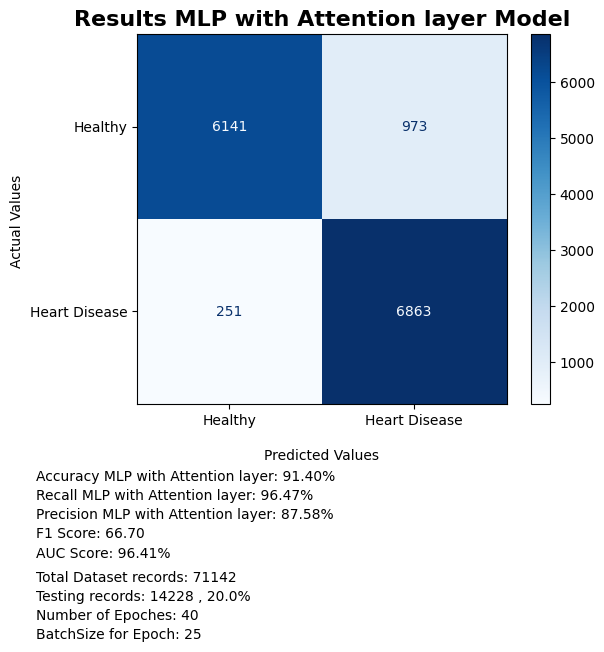

In [8]:
threshold = 0.5  # Adjust the threshold as needed
binary_predictions = (model2.predict(X_test_scaler) > threshold).astype(int)

cm = confusion_matrix(y_test_float64, binary_predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Healthy', 'Heart Disease'])

display.plot(cmap=plt.cm.Blues, values_format=".4g") 


method = "MLP with Attention layer"
display.ax_.set_title("Results {} Model".format(method),fontsize=16, fontweight='bold')
display.ax_.set_xlabel('\nPredicted Values')
display.ax_.set_ylabel('Actual Values ')

accuracyString ="Accuracy {}: {:.2f}%".format(method, accuracy*100.0 ) 
recallString =  'Recall {}: {:.2f}%'.format(method, recall_value* 100.0)
precisionString = 'Precision {}: {:.2f}%'.format(method, precision_value * 100.0) 
f1String = "F1 Score: {:.2f}".format(f1_score_value[0] * 100.0)
featureListString = "AUC Score: {:.2f}%".format(auc_value * 100.0)
totaldataSetString = "Total Dataset records: {}".format((len(features)+len(X_test_scaler)))
testingdataSetString = "Testing records: {} , {:.1f}%".format(len(X_test_scaler), ( ( len(X_test_scaler) / (len(features)+len(X_test_scaler)) )*100.0  ))
numberOfEpochsString = "Number of Epoches: {}".format(numberOfEpochs)
batchSizeOfTrainingString = "BatchSize for Epoch: {}".format(batchSizeOfTraining)

display.figure_.text(0.010, -0.05,  accuracyString, horizontalalignment='left', wrap=False )  
display.figure_.text(0.010, -0.09,  recallString, horizontalalignment='left', wrap=False )      
display.figure_.text(0.010, -0.13,  precisionString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.17,  f1String, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.21,  featureListString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.26,  totaldataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.30,  testingdataSetString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.34,  numberOfEpochsString, horizontalalignment='left', wrap=False ) 
display.figure_.text(0.010, -0.38,  batchSizeOfTrainingString, horizontalalignment='left', wrap=False ) 
 
picturePath = "{}Model_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
print("{} Confusion Matrix saved:: path: {}".format(method, picturePath))

mplot.show()
mplot.close()


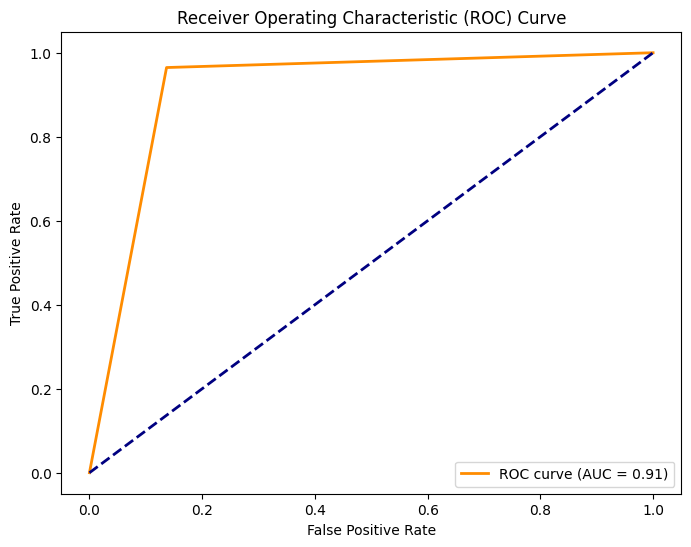

In [9]:
# Calculate AUC
auc_score = roc_auc_score(y_test, binary_predictions)
# Calculate ROC Curve
fpr, tpr, _ = roc_curve(y_test, binary_predictions)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')

picturePath = "{}Model_Evaluation_ROC_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

plt.show()
plt.close()




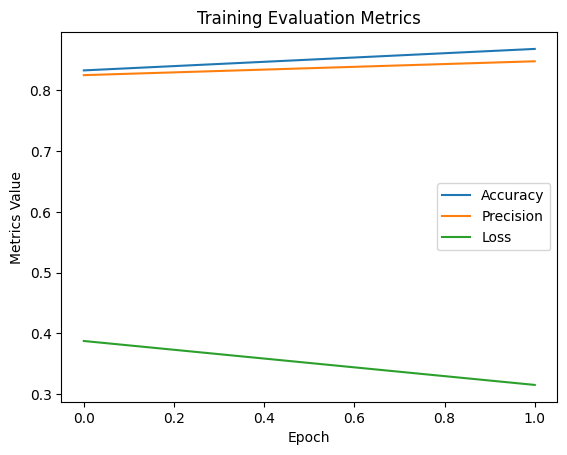

In [10]:
import matplotlib.pyplot as plt
# Plot accuracy
plt.plot(history.history['accuracy'], label='Accuracy')
# Plot precision
plt.plot(history.history['precision'], label='Precision' )
# Plot loss
plt.plot(history.history['loss'], label='Loss')

# Set plot labels and title
plt.title('Training Evaluation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Metrics Value')

# Add legend
plt.legend()

picturePath = "{}Model_Training_Evaluation_{}_{}_Epoch_{}.png".format(dataSetResultDirectory, method, dataSetName, numberOfEpochs)
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')

plt.show()
plt.close()


In [11]:
percentage = 0.07
numberOfFeatures = int(len(features) *percentage)
print("Total Features: {} -> Selected for SHAP:: {}".format(len(features), numberOfFeatures))
featuresForShap = X_train.columns #features[0:numberOfFeatures]
#print(" Features Name: {}".format(  featuresForShap))

numberOftest = int(len(X_test_scaler) * percentage)
print("Total Test: {} -> Selected for SHAP:: {}".format(len(X_test_scaler), numberOftest))
testForShap = X_test_scaler[0:len(featuresForShap)]
testForShap = X_test_scaler[0:numberOftest]
#print(" testForShap Name: {}".format(  testForShap))

shap_explainer = shap.Explainer(model, feature_names=featuresForShap, masker=shap.maskers.Independent(data=testForShap)) 

#shap_explainer = shap.Explainer(model) 


Total Features: 56914 -> Selected for SHAP:: 3983
Total Test: 14228 -> Selected for SHAP:: 995


In [12]:
shap_values = shap_explainer.shap_values(testForShap)  

PermutationExplainer explainer: 996it [02:33,  6.28it/s]                         




--------------------------------------------------
--------------------------------------------------
Top SHAP values:
0, 1, Blood-Rel-Diabetes, 0.008166778183568245
1, 0, Triglycerides, 0.005776828574968382
2, 4, Cholesterol, 0.005277468538865546
3, 2, Gender, 0.003938773185500308
4, 15, Weight, 0.00252259271741176
5, 16, Protein, 0.0024671625528747496
6, 6, Diabetes, 0.0024228451920529684
7, 5, Body-Mass-Index, 0.0022356489313952073
8, 19, Uric.Acid, 0.0017803594974050128
9, 12, Phosphorus, 0.0015063073817826228
10, 8, Basophils, 0.0010351948012181768
11, 7, Diastolic, 0.0005178837153181593
12, 10, Height, 0.00031405942486609076
13, 14, LDH, -8.675959575458243e-05
14, 17, White-Blood-Cells, -0.0008389748293993662
15, 3, Blood-Rel-Stroke, -0.0012404857157780266
16, 13, Total-Cholesterol, -0.002245674389531239
17, 11, Albumin, -0.0022728389716955726
18, 9, Eosinophils, -0.0029172022304098186


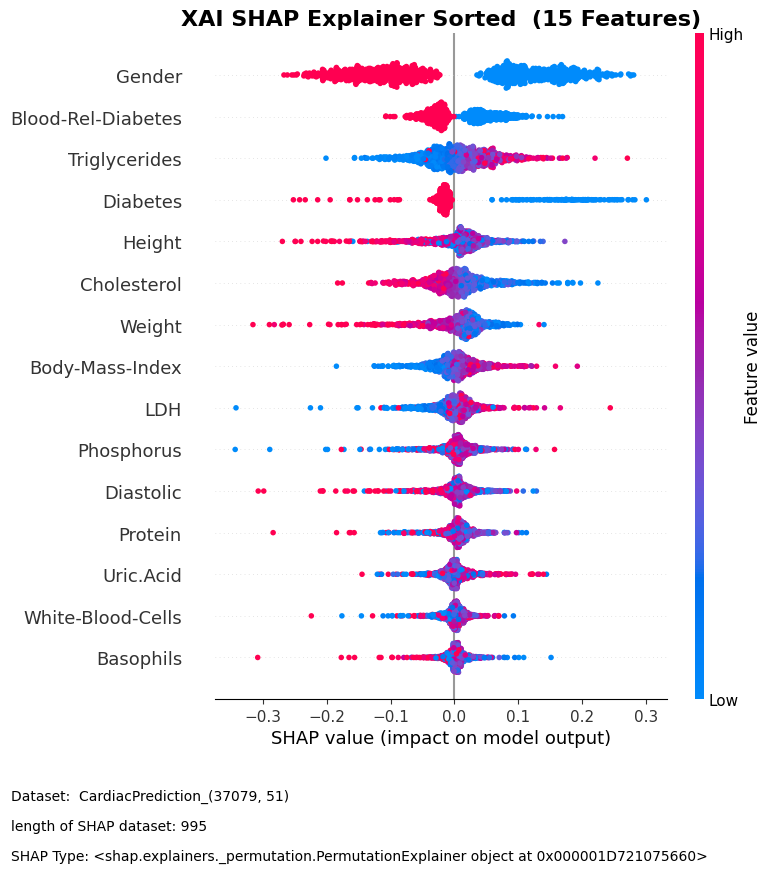

In [13]:
# Calculate feature importance based on the mean absolute SHAP values
feature_names = X.columns.tolist()
# Calculate average SHAP values across all instances
avg_shap_values = np.mean(shap_values, axis=0)
# Print average SHAP values according to feature names 

avg_shap_values2 = {}

howManyFeatures = 15
# Calculate feature importance based on the mean absolute SHAP values
feature_importance = (shap_values).mean(axis=0)
top_features_indices_Sorted = np.argsort(feature_importance)[::-1] 
top_features_indices = np.argsort(feature_importance)[::-1][:howManyFeatures]
# Select only the top features and corresponding SHAP values
featureNamesSHAP = X.columns[top_features_indices_Sorted]
top_features = testForShap[:, top_features_indices_Sorted]
top_shap_values = shap_values[:, top_features_indices_Sorted] 

print("\n\n--------------------------------------------------")
print("--------------------------------------------------")
print("Top SHAP values:")
for i in range(len(top_features_indices_Sorted)-1):
    feature_index = top_features_indices_Sorted[i]
    feature_name = feature_names[feature_index]
    shap_value = (top_shap_values[:, i]).mean(axis=0) #np.mean(np.abs(shap_values[:, i]))
    avg_shap_values2[i]= (shap_value * 100.0)
    print(f"{i}, {feature_index}, {feature_name}, {shap_value }")
    #print(f"{feature_name}, { shap_value}")
 
top_10_shap_values = shap_values[:, top_features_indices] 
top_10_feature_names = X.columns[top_features_indices]
# Create a DataFrame for visualization


df_top_10 = pd.DataFrame(data=top_10_shap_values, columns=top_10_feature_names)

shap.summary_plot(top_10_shap_values, testForShap[:, top_features_indices], feature_names=top_10_feature_names, show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap))
shapTypeString ="SHAP Type: {}".format(repr(shap_explainer)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   
ax.figure.text(0.020, -0.13,  shapTypeString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_Explainer_Bar_{}_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
mplot.show()
#os.startfile(picturePath)
mplot.close()






Sorted Average SHAP values:
Blood-Rel-Diabetes, 0.008166778183568242
Triglycerides, 0.005776828574968384
Cholesterol, 0.00527746853886555
Gender, 0.0039387731855003065
Weight, 0.0025225927174117604
Protein, 0.0024671625528747522
Diabetes, 0.002422845192052967
Body-Mass-Index, 0.002235648931395202
Uric.Acid, 0.0017803594974050135
Phosphorus, 0.0015063073817826213
Basophils, 0.0010351948012181753
Diastolic, 0.0005178837153181591
Height, 0.0003140594248660904
LDH, -8.675959575458239e-05
White-Blood-Cells, -0.000838974829399367
Blood-Rel-Stroke, -0.0012404857157780264
Total-Cholesterol, -0.0022456743895312393
Albumin, -0.0022728389716955735
Eosinophils, -0.0029172022304098225
AST, -0.003054784750673498


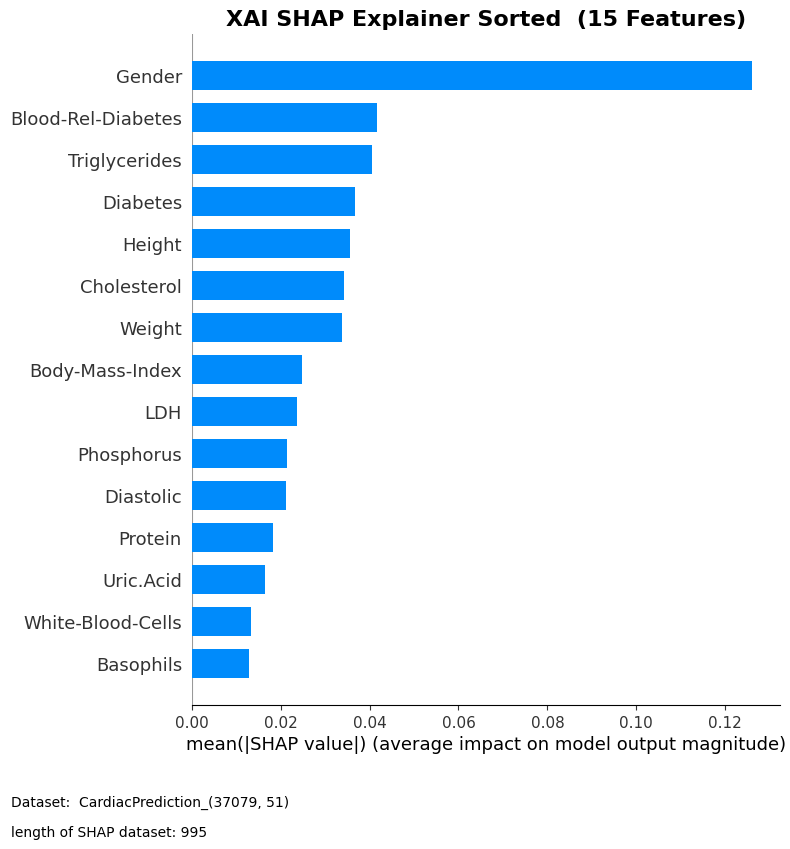

In [14]:
avg_shap_values = np.mean(shap_values, axis=0)
# Get indices that would sort the average SHAP values
sorted_Average_indices = np.argsort(avg_shap_values)[::-1]
# Arrange feature names and average SHAP values in ascending order
sorted_feature_names = [feature_names[i] for i in sorted_Average_indices]
sorted_avg_shap_values = avg_shap_values[sorted_Average_indices]
# Print sorted feature names and average SHAP values
print("\n\nSorted Average SHAP values:")
for i in range(len(sorted_feature_names)):
    print(f"{sorted_feature_names[i]}, {sorted_avg_shap_values[i]}")

 

shap.summary_plot(top_10_shap_values, testForShap[:, top_features_indices], feature_names=top_10_feature_names, plot_type="bar", show=False)

ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_Explainer_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.show()
#os.startfile(picturePath)
mplot.close()

In [ ]:
# Plot the summary Bar
shap.summary_plot(top_10_shap_values, testForShap[:, top_features_indices], feature_names=top_10_feature_names, plot_type="bar", show=False)
ax = mplot.gca() 
ax.set_title("XAI SHAP Explainer Sorted  ({} Features)".format(howManyFeatures) ,fontsize=16, fontweight='bold')     
dataSetString = "Dataset:  {}".format(dataSetName)
testingDatasetString ="length of SHAP dataset: {}".format(len(testForShap)) 
ax.figure.text(0.020, -0.05,  dataSetString, horizontalalignment='left', wrap=False )  
ax.figure.text(0.020, -0.09,  testingDatasetString, horizontalalignment='left', wrap=False )   

picturePath = "{}XAI_SHAP_Explainer_Bar_{}_Sorted_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
mplot.savefig(picturePath,  dpi=300, bbox_inches='tight')
#mplot.show()
#os.startfile(picturePath)
mplot.close()

In [ ]:
shap.summary_plot(top_shap_values, testForShap[:, top_features_indices], feature_names=featureNamesSHAP, plot_type="violin", show=False, plot_size=(12, 6))

picturePath = "{}XAI_SHAP_Explainer_Violin_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
shap.summary_plot(top_shap_values, testForShap[:, top_features_indices], feature_names=featureNamesSHAP, plot_type="layered_violin", show=False )

picturePath = "{}XAI_SHAP_Explainer_layered_violin_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
import matplotlib.pyplot as plt

# Plotting with Seaborn's violinplot
plt.figure(figsize=(15, 6))
sns.violinplot(data=df_top_10, inner="quartile", palette="muted") 
plt.title('MLP Model with SHAP (XAI) Violin Plot')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Violinplot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Set the x-axis range
x_axis_range = (-0.25, 0.25)  # Adjust the range as needed
# Plotting with Seaborn's kdeplot
plt.figure(figsize=(15, 6))
for feature in top_10_feature_names:
    sns.kdeplot(data=df_top_10[feature], label=feature, common_norm=False, common_grid=True, fill=True, clip=x_axis_range)
 
plt.title('MLP Model with SHAP (XAI) KDE Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Density')
plt.legend()
picturePath = "{}XAI_SHAP_Explainer_SNS_KDEplot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Set the x-axis range
x_axis_range = (-0.3, 0.3)  # Adjust the range as needed
# Plotting with Seaborn's kdeplot
plt.figure(figsize=(15, 6))
for feature in top_10_feature_names:
    sns.kdeplot(data=df_top_10[feature], label=feature, common_norm=True, common_grid=True, fill=True, clip=x_axis_range)
 
plt.title('MLP Model with SHAP (XAI) KDE Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Density')
plt.legend()
picturePath = "{}XAI_SHAP_Explainer_SNS_KDEplot_2_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Plotting a Bubble Chart
plt.figure(figsize=(12, 6))

for i, feature in enumerate(top_10_feature_names):
    size = np.abs(df_top_10[feature]) * 100  # Adjust the scale as needed
    plt.scatter(x=[i] * len(df_top_10), y=df_top_10[feature], s=size, label=feature, alpha=0.6)
 
plt.title('MLP Model with SHAP (XAI) Bubble Chart')
plt.xlabel('Feature Index')
plt.ylabel('SHAP Values')
plt.xticks(range(len(top_10_feature_names)), top_10_feature_names, rotation=45, ha='right')
#plt.legend()

picturePath = "{}XAI_SHAP_Explainer_SNS_BubbleChart_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
22sfsdf
# Plotting a boxplot for the top 10 features
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_10, orient='v', palette='Set2')


plt.title('MLP Model with SHAP (XAI) Box Plot')
plt.xlabel('SHAP Values')
plt.ylabel('Features')
plt.xticks(range(len(top_10_feature_names)), top_10_feature_names, rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_BoxPlot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Plotting an area chart for all SHAP values of the top 10 features
plt.figure(figsize=(15, 10))
for feature in top_10_feature_names:
    sns.lineplot(x=range(df_top_10.shape[0]), y=df_top_10[feature], label=feature)
 
plt.title('MLP Model with SHAP (XAI) Area Chart')

plt.xlabel('Instances')
plt.ylabel('SHAP Values')
plt.legend(loc='upper right')

picturePath = "{}XAI_SHAP_Explainer_SNS_AreaChart_{}_numberOfSamples_{}.png".format(dataSetResultDirectory,  dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Assuming your features are in a pandas DataFrame, you can access feature names
feature_names = X.columns.tolist()
# Get the top 3 features based on their absolute average SHAP values
top_3_feature_indices = np.argsort(np.abs(shap_values.mean(0)))[-3:]
top_3_feature_names = [feature_names[i] for i in top_3_feature_indices]
# Extract SHAP values for the top 3 features
shap_values_top_3 = shap_values[:, top_3_feature_indices]
# Create a DataFrame for visualization
df_top_3 = pd.DataFrame(data=shap_values_top_3, columns=top_3_feature_names)

# Create a 3D bubble plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
 

# Scatter plot with adjusted size and color
scatter = ax.scatter(df_top_3[top_3_feature_names[0]], df_top_3[top_3_feature_names[1]], df_top_3[top_3_feature_names[2]],
                     s=1500 * np.abs(df_top_3.mean(axis=1)),  # Adjust the size
                     c=df_top_3.mean(axis=1), cmap='viridis', alpha=0.9, edgecolors='w', linewidth=0.8)  # Adjust the color

# Add labels and title
ax.set_xlabel(top_3_feature_names[0])
ax.set_ylabel(top_3_feature_names[1])
ax.set_zlabel(top_3_feature_names[2])
ax.set_title('3D Bubble Plot of Top 3 Features')
plt.title('MLP Model with SHAP (XAI) 3D Bubble Plot')


# Add colorbar
colorbar = plt.colorbar(scatter, ax=ax, label='Average SHAP Value')

picturePath = "{}XAI_SHAP_Explainer_SNS_BubblePlot_3D_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()

In [ ]:
# Plotting with Seaborn's swarmplot (Beeswarm plot) 
plt.figure(figsize=(12, 6))
sns.stripplot(data=df_top_10, palette="muted", size=3, jitter=True)  # Use jitter=True for strip plot

plt.title('MLP Model with SHAP (XAI) Strip Plot')
plt.ylabel('SHAP Values')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Stripplot_{}_numberOfSamples_{}.png".format(dataSetResultDirectory,  dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [27]:
import datetime
currentDateTime = datetime.datetime.now() 
currentDateTime = currentDateTime.strftime("%Y%m%d_%H%M") 
modelPath = "{}model02_trained_{}_{}_{}percent.model".format(dataSetResultDirectory, dataSetName, currentDateTime, accuracy)
print(modelPath)
model2.save(modelPath)

./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/model02_trained_CardiacPrediction_(37079, 51)_20240111_1214_0.9139724373817444percent.model
INFO:tensorflow:Assets written to: ./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/model02_trained_CardiacPrediction_(37079, 51)_20240111_1214_0.9139724373817444percent.model\assets


INFO:tensorflow:Assets written to: ./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/model02_trained_CardiacPrediction_(37079, 51)_20240111_1214_0.9139724373817444percent.model\assets


In [28]:
import pickle

import datetime
currentDateTime = datetime.datetime.now() 
currentDateTime = currentDateTime.strftime("%Y%m%d_%H%M") 
explainerPath = "{}ShapeExplainer_{}_{:.2f}percent.pkl".format(dataSetResultDirectory, currentDateTime, (accuracy*100))
print(explainerPath)

explainerValuePath = "{}ShapeExplainerValues_{}_{:.2f}percent.pkl".format(dataSetResultDirectory, currentDateTime, (accuracy*100))
print(explainerValuePath)
  
# Save the SHAP values to a file using pickle
with open(explainerValuePath, 'wb') as shap_values_file:
    pickle.dump(shap_values, shap_values_file)


# Save the SHAP values to a file using pickle
with open(explainerPath, 'wb') as explainer_file:
    pickle.dump(shap_explainer, explainer_file)

 

# To load the saved explainer and SHAP values later:
# with open('shap_explainer.pkl', 'rb') as explainer_file:
#     loaded_explainer = pickle.load(explainer_file)
# 
# with open('shap_values.pkl', 'rb') as shap_values_file:
#     loaded_shap_values = pickle.load(shap_values_file)
    


./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/ShapeExplainer_20240111_1214_91.40percent.pkl
./DatasetResults_MLP_After_XAI_Features_Selection_Experiment_1_CardiacPrediction/ShapeExplainerValues_20240111_1214_91.40percent.pkl


In [ ]:
#  swarmplot (Beeswarm plot)
plt.figure(figsize=(12, 6))
sns.swarmplot(data=df_top_10, palette="muted", size=3) 
plt.title('MLP Model with SHAP (XAI) Beeswarm Plot')
plt.ylabel('SHAP Values')
plt.xticks(rotation=45, ha='right')

picturePath = "{}XAI_SHAP_Explainer_SNS_Beeswarmplot_{}_{}_numberOfSamples_{}.png".format(dataSetResultDirectory, method, dataSetName, len(testForShap))
plt.savefig(picturePath,  dpi=300, bbox_inches='tight')
plt.show()
plt.close()